In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
f1_laps = pd.read_csv("../data/f1_laps_features.csv")

# Feature Engineering for Lap Time Prediction

Adding comprehensive features to improve model accuracy

In [3]:
# === 1. TIRE-RELATED FEATURES ===
print("Creating tire-related features...")

# Tire compound encoding (SOFT=1, MEDIUM=2, HARD=3)
tire_compound_map = {'SOFT': 1, 'MEDIUM': 2, 'HARD': 3}
f1_laps['TireCompound_encoded'] = f1_laps['TireCompound'].map(tire_compound_map).fillna(2)

# Tire life remaining (assume max 40 laps for SOFT, 50 for MEDIUM, 60 for HARD)
tire_life_map = {'SOFT': 40, 'MEDIUM': 50, 'HARD': 60}
f1_laps['MaxTireLife'] = f1_laps['TireCompound'].map(tire_life_map).fillna(50)
f1_laps['TireLifeRemaining'] = f1_laps['MaxTireLife'] - f1_laps['TireAge']
f1_laps['TireLifeRemaining'] = f1_laps['TireLifeRemaining'].clip(lower=0)

# Tire degradation rate (use existing tire_degradation if available)
if 'tire_degradation' in f1_laps.columns:
    f1_laps['TireDegradationRate'] = f1_laps['tire_degradation'].fillna(0)
else:
    # Calculate degradation as lap time change within stint
    f1_laps['TireDegradationRate'] = f1_laps.groupby(['Driver', 'Race', 'TireCompound'])['LapTime_seconds'].diff().fillna(0)

# Fresh tire indicator (first 3 laps on new tires)
f1_laps['IsFreshTire'] = (f1_laps['TireAge'] <= 3).astype(int)

# Tire wear percentage
f1_laps['TireWearPct'] = (f1_laps['TireAge'] / f1_laps['MaxTireLife'] * 100).clip(upper=100)

print(f"✓ Created 7 tire-related features")
print(f"  - TireCompound_encoded, TireLifeRemaining, TireDegradationRate")
print(f"  - IsFreshTire, TireWearPct, MaxTireLife")

Creating tire-related features...
✓ Created 7 tire-related features
  - TireCompound_encoded, TireLifeRemaining, TireDegradationRate
  - IsFreshTire, TireWearPct, MaxTireLife


In [4]:
# === 2. TRACK POSITION & TRAFFIC FEATURES ===
print("Creating track position and traffic features...")

# Sort data properly for position-based calculations
f1_laps = f1_laps.sort_values(['Year', 'Race', 'LapNumber', 'Position']).reset_index(drop=True)

# Gap to car ahead (time difference)
f1_laps['GapToCarAhead'] = f1_laps.groupby(['Year', 'Race', 'LapNumber'])['LapTime_seconds'].diff().fillna(0).abs()

# Gap to car behind
f1_laps['GapToCarBehind'] = f1_laps.groupby(['Year', 'Race', 'LapNumber'])['LapTime_seconds'].diff(-1).fillna(0).abs()

# DRS available indicator (gap to ahead < 1 second equivalent ~1% lap time)
f1_laps['DRS_Available'] = (f1_laps['GapToCarAhead'] < 1.0).astype(int)

# Traffic density (number of cars within ~3 seconds - use position as proxy)
f1_laps['TrafficDensity'] = f1_laps.groupby(['Year', 'Race', 'LapNumber'])['Position'].transform(
    lambda x: ((x - x.mean()).abs() < 3).sum()
)

print(f"✓ Created 4 track position/traffic features")
print(f"  - GapToCarAhead, GapToCarBehind, DRS_Available, TrafficDensity")

Creating track position and traffic features...
✓ Created 4 track position/traffic features
  - GapToCarAhead, GapToCarBehind, DRS_Available, TrafficDensity


In [5]:
# === 3. FUEL LOAD & RACE PROGRESSION FEATURES ===
print("Creating fuel load and race progression features...")

# Get max laps per race
f1_laps['MaxLapsInRace'] = f1_laps.groupby(['Year', 'Race'])['LapNumber'].transform('max')

# Fuel load proxy (normalized remaining laps - heavier car at start)
f1_laps['FuelLoadProxy'] = (f1_laps['MaxLapsInRace'] - f1_laps['LapNumber']) / f1_laps['MaxLapsInRace']

# Race phase encoded (0=Early, 1=Middle, 2=Late)
if 'race_phase' in f1_laps.columns:
    phase_map = {'Early': 0, 'Middle': 1, 'Late': 2}
    f1_laps['RacePhase_encoded'] = f1_laps['race_phase'].map(phase_map).fillna(1)
else:
    f1_laps['RacePhase_encoded'] = pd.cut(f1_laps['LapNumber'], 
                                           bins=[0, 15, 40, 1000], 
                                           labels=[0, 1, 2]).astype(int)

# Laps remaining
f1_laps['LapsRemaining'] = f1_laps['MaxLapsInRace'] - f1_laps['LapNumber']

# Normalized lap progress (0 to 1)
f1_laps['LapProgress'] = f1_laps['LapNumber'] / f1_laps['MaxLapsInRace']

# Stint lap number (laps since tire change - use TireAge as proxy)
f1_laps['StintLapNumber'] = f1_laps['TireAge']

print(f"✓ Created 6 fuel/progression features")
print(f"  - FuelLoadProxy, RacePhase_encoded, LapsRemaining")
print(f"  - LapProgress, StintLapNumber, MaxLapsInRace")

Creating fuel load and race progression features...
✓ Created 6 fuel/progression features
  - FuelLoadProxy, RacePhase_encoded, LapsRemaining
  - LapProgress, StintLapNumber, MaxLapsInRace


In [6]:
# === 4. DRIVER & TEAM FORM METRICS ===
print("Creating driver and team form features...")

# Rolling average lap time (last 3 laps)
f1_laps['RollingAvgLapTime_3'] = f1_laps.groupby('Driver')['LapTime_seconds'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling average lap time (last 5 laps)
f1_laps['RollingAvgLapTime_5'] = f1_laps.groupby('Driver')['LapTime_seconds'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean()
)

# Lap time standard deviation (last 5 laps - consistency metric)
f1_laps['LapTimeStd_5'] = f1_laps.groupby('Driver')['LapTime_seconds'].transform(
    lambda x: x.rolling(window=5, min_periods=1).std()
).fillna(0)

# Team average pace (per race)
f1_laps['TeamAvgPace'] = f1_laps.groupby(['Year', 'Race', 'Team'])['LapTime_seconds'].transform('mean')

# Driver pace vs team average
f1_laps['DriverVsTeamPace'] = f1_laps['LapTime_seconds'] - f1_laps['TeamAvgPace']

# Driver best lap in race (so far)
f1_laps['DriverBestLapInRace'] = f1_laps.groupby(['Year', 'Race', 'Driver'])['LapTime_seconds'].transform('min')

# Percentage off best lap
f1_laps['PctOffBestLap'] = ((f1_laps['LapTime_seconds'] - f1_laps['DriverBestLapInRace']) / 
                             f1_laps['DriverBestLapInRace'] * 100).fillna(0)

print(f"✓ Created 7 driver/team form features")
print(f"  - RollingAvgLapTime_3, RollingAvgLapTime_5, LapTimeStd_5")
print(f"  - TeamAvgPace, DriverVsTeamPace, DriverBestLapInRace, PctOffBestLap")

Creating driver and team form features...
✓ Created 7 driver/team form features
  - RollingAvgLapTime_3, RollingAvgLapTime_5, LapTimeStd_5
  - TeamAvgPace, DriverVsTeamPace, DriverBestLapInRace, PctOffBestLap


In [7]:
# === 5. ENVIRONMENTAL & SESSION FACTORS ===
print("Creating environmental and session features...")

# Track evolution (grip improves as session progresses)
f1_laps['TrackEvolution'] = f1_laps.groupby(['Year', 'Race'])['LapNumber'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1)  # 0 to 1 scale
)

# Lap number normalized (position in race)
f1_laps['LapNumber_normalized'] = f1_laps['LapNumber'] / f1_laps['MaxLapsInRace']

# Is outlap (first lap on new tires - usually slower)
f1_laps['IsOutlap'] = (f1_laps['TireAge'] == 0).astype(int)

# Is inlap (preparing for pit stop - can identify by tire age near max or sudden tire change)
# Detect tire compound changes for each driver in a race
f1_laps['TireCompoundChange'] = f1_laps.groupby(['Year', 'Race', 'Driver'])['TireCompound'].transform(
    lambda x: (x != x.shift(1)).astype(int)
)
# Inlap is the lap before tire change
f1_laps['IsInlap'] = f1_laps.groupby(['Year', 'Race', 'Driver'])['TireCompoundChange'].shift(-1).fillna(0).astype(int)

# Old tires indicator (tire age > 80% of max life)
f1_laps['OldTiresIndicator'] = (f1_laps['TireWearPct'] > 80).astype(int)

print(f"✓ Created 6 environmental/session features")
print(f"  - TrackEvolution, LapNumber_normalized, IsOutlap")
print(f"  - IsInlap, OldTiresIndicator, TireCompoundChange")

Creating environmental and session features...
✓ Created 6 environmental/session features
  - TrackEvolution, LapNumber_normalized, IsOutlap
  - IsInlap, OldTiresIndicator, TireCompoundChange


In [ ]:
# === 6. FEATURE SUMMARY ===
print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)

# Count new features
new_features = [
    # Tire features
    'TireCompound_encoded', 'TireLifeRemaining', 'TireDegradationRate', 
    'IsFreshTire', 'TireWearPct', 'MaxTireLife',
    # Position/Traffic
    'GapToCarAhead', 'GapToCarBehind', 'DRS_Available', 'TrafficDensity',
    # Fuel/Progression
    'FuelLoadProxy', 'RacePhase_encoded', 'LapsRemaining', 
    'LapProgress', 'StintLapNumber', 'MaxLapsInRace',
    # Driver/Team Form
    'RollingAvgLapTime_3', 'RollingAvgLapTime_5', 'LapTimeStd_5',
    'TeamAvgPace', 'DriverVsTeamPace', 'DriverBestLapInRace', 'PctOffBestLap',
    # Environmental
    'TrackEvolution', 'LapNumber_normalized', 'IsOutlap', 
    'IsInlap', 'OldTiresIndicator', 'TireCompoundChange'
]

available_new_features = [f for f in new_features if f in f1_laps.columns]


FEATURE ENGINEERING COMPLETE

Total new features created: 29
Total features in dataset: 45
Total rows: 9,862

New features available:
   1. TireCompound_encoded
   2. TireLifeRemaining
   3. TireDegradationRate
   4. IsFreshTire
   5. TireWearPct
   6. MaxTireLife
   7. GapToCarAhead
   8. GapToCarBehind
   9. DRS_Available
  10. TrafficDensity
  11. FuelLoadProxy
  12. RacePhase_encoded
  13. LapsRemaining
  14. LapProgress
  15. StintLapNumber
  16. MaxLapsInRace
  17. RollingAvgLapTime_3
  18. RollingAvgLapTime_5
  19. LapTimeStd_5
  20. TeamAvgPace
  21. DriverVsTeamPace
  22. DriverBestLapInRace
  23. PctOffBestLap
  24. TrackEvolution
  25. LapNumber_normalized
  26. IsOutlap
  27. IsInlap
  28. OldTiresIndicator
  29. TireCompoundChange



In [9]:
# === 7. DATA QUALITY CHECK ===
print("Checking data quality after feature engineering...\n")

# Check for missing values
missing_summary = f1_laps[available_new_features].isnull().sum()
missing_features = missing_summary[missing_summary > 0]

if len(missing_features) > 0:
    print(f"⚠ Features with missing values:")
    for feat, count in missing_features.items():
        pct = count / len(f1_laps) * 100
        print(f"  - {feat}: {count:,} ({pct:.1f}%)")
else:
    print("✓ No missing values in new features!")

# Check for infinite values
inf_check = f1_laps[available_new_features].apply(lambda x: np.isinf(x).sum())
inf_features = inf_check[inf_check > 0]

if len(inf_features) > 0:
    print(f"\n⚠ Features with infinite values:")
    for feat, count in inf_features.items():
        print(f"  - {feat}: {count:,}")
    # Replace inf with nan
    f1_laps[available_new_features] = f1_laps[available_new_features].replace([np.inf, -np.inf], np.nan)
    print("  → Replaced infinite values with NaN")
else:
    print("\n✓ No infinite values detected!")

# Fill any remaining NaNs with 0 or median
for feat in available_new_features:
    if f1_laps[feat].isnull().sum() > 0:
        if f1_laps[feat].dtype in ['float64', 'int64']:
            fill_value = f1_laps[feat].median()
            f1_laps[feat].fillna(fill_value, inplace=True)
            
print(f"\n✓ Data quality check complete!")
print(f"Final dataset shape: {f1_laps.shape}")

Checking data quality after feature engineering...

✓ No missing values in new features!

✓ No infinite values detected!

✓ Data quality check complete!
Final dataset shape: (9862, 45)


## Updated Model Training

Now training with all enhanced features for better lap time prediction

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb

In [11]:
f1_laps.head()

,Year,Race,Driver,Team,LapNumber,LapTime_seconds,Position,TireCompound,TireAge,PositionGroup,...,TeamAvgPace,DriverVsTeamPace,DriverBestLapInRace,PctOffBestLap,TrackEvolution,LapNumber_normalized,IsOutlap,TireCompoundChange,IsInlap,OldTiresIndicator
0,2025,16,VER,Red Bull Racing,1.0,87.159,1.0,MEDIUM,1.0,Top 5,...,83.861802,3.297198,81.003,7.599719,0.0,0.018868,0,1,0,0
1,2025,16,NOR,McLaren,1.0,87.430,2.0,MEDIUM,1.0,Top 5,...,83.483094,3.946906,80.901,8.070358,0.0,0.018868,0,1,0,0
2,2025,16,PIA,McLaren,1.0,87.992,3.0,MEDIUM,1.0,Top 5,...,83.483094,4.508906,81.245,8.304511,0.0,0.018868,0,1,0,0
3,2025,16,LEC,Ferrari,1.0,88.280,4.0,MEDIUM,1.0,Top 5,...,83.695500,4.584500,81.294,8.593500,0.0,0.018868,0,1,0,0
4,2025,16,RUS,Mercedes,1.0,88.907,5.0,MEDIUM,1.0,Top 5,...,83.927292,4.979708,81.800,8.688264,0.0,0.018868,0,1,0,0


In [12]:
# Define comprehensive feature set
base_features = ['Race', 'Driver', 'Team', 'Position', 'TireCompound', 'TireAge', 
                 'driver_win_rate', 'team_reliability']

# New engineered features
tire_features = ['TireCompound_encoded', 'TireLifeRemaining', 'TireDegradationRate', 
                 'IsFreshTire', 'TireWearPct']

traffic_features = ['GapToCarAhead', 'GapToCarBehind', 'DRS_Available', 'TrafficDensity']

progression_features = ['FuelLoadProxy', 'RacePhase_encoded', 'LapsRemaining', 
                        'LapProgress', 'StintLapNumber']

form_features = ['RollingAvgLapTime_3', 'RollingAvgLapTime_5', 'LapTimeStd_5',
                 'TeamAvgPace', 'DriverVsTeamPace', 'PctOffBestLap']

session_features = ['TrackEvolution', 'LapNumber_normalized', 'IsOutlap', 
                    'IsInlap', 'OldTiresIndicator']

# Combine all features
all_features = (base_features + tire_features + traffic_features + 
                progression_features + form_features + session_features)

# Filter to only available features
features = [f for f in all_features if f in f1_laps.columns]

print(f"Using {len(features)} features for training:")
print(f"  - Base features: {len([f for f in base_features if f in features])}")
print(f"  - Tire features: {len([f for f in tire_features if f in features])}")
print(f"  - Traffic features: {len([f for f in traffic_features if f in features])}")
print(f"  - Progression features: {len([f for f in progression_features if f in features])}")
print(f"  - Form features: {len([f for f in form_features if f in features])}")
print(f"  - Session features: {len([f for f in session_features if f in features])}")

X = f1_laps[features]
y = f1_laps['LapTime_seconds']

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

Using 33 features for training:
  - Base features: 8
  - Tire features: 5
  - Traffic features: 4
  - Progression features: 5
  - Form features: 6
  - Session features: 5

X shape: (9862, 33)
y shape: (9862,)


In [13]:
available_cols = [col for col in features if col in f1_laps.columns]

# Categorical features (for encoding)
categorical_features = [col for col in ['Team', 'Driver', 'TireCompound', 'Race'] 
                        if col in available_cols]

# Numerical features (for scaling)
numerical_features = [col for col in available_cols if col not in categorical_features]

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {len(numerical_features)} features")

Categorical features (4): ['Team', 'Driver', 'TireCompound', 'Race']
Numerical features (29): 29 features


In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

Training set: 7,889 samples
Test set: 1,973 samples


In [16]:
xgb_regressor = xgb.XGBRegressor(n_estimators=1000,
                                   learning_rate=0.01,
                                   max_depth=5,
                                   random_state=42)


In [17]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_regressor)
])

In [18]:
# Train the pipeline
print("Training XGBoost model with enhanced features...")
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n{'='*60}")
print(f"MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Mean Absolute Error: {mae:.3f} seconds")
print(f"R² Score: {r2:.4f}")
print(f"Average lap time: {y_test.mean():.3f} seconds")
print(f"Error as % of avg lap time: {(mae/y_test.mean())*100:.2f}%")
print(f"{'='*60}")

pipeline

Training XGBoost model with enhanced features...

MODEL PERFORMANCE
Mean Absolute Error: 0.215 seconds
R² Score: 0.9979
Average lap time: 91.964 seconds
Error as % of avg lap time: 0.23%


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Analyzing feature importance...


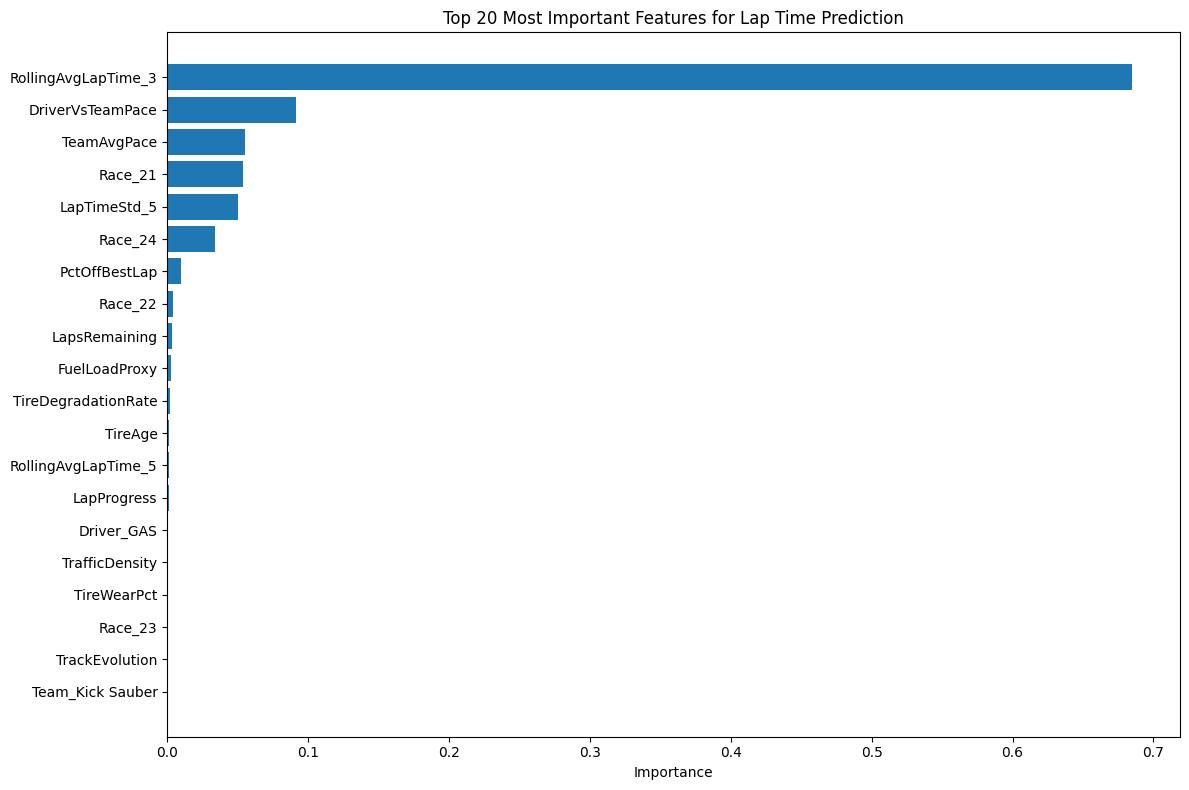


Top 10 most important features:
  RollingAvgLapTime_3: 0.6846
  DriverVsTeamPace: 0.0910
  TeamAvgPace: 0.0550
  Race_21: 0.0538
  LapTimeStd_5: 0.0504
  Race_24: 0.0340
  PctOffBestLap: 0.0099
  Race_22: 0.0038
  LapsRemaining: 0.0032
  FuelLoadProxy: 0.0027


In [19]:
# Feature importance analysis
print("Analyzing feature importance...")

# Get feature names after preprocessing
feature_names_encoded = []

# Add numerical features
feature_names_encoded.extend(numerical_features)

# Add encoded categorical features
if len(categorical_features) > 0:
    cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']
    if hasattr(cat_encoder, 'get_feature_names_out'):
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
        feature_names_encoded.extend(cat_feature_names)

# Get feature importances from XGBoost
xgb_model = pipeline.named_steps['regressor']
importances = xgb_model.feature_importances_

# Create DataFrame with available features
n_features = min(len(importances), len(feature_names_encoded))
feature_importance_df = pd.DataFrame({
    'feature': feature_names_encoded[:n_features],
    'importance': importances[:n_features]
}).sort_values('importance', ascending=False).head(20)

# Plot top 20 features
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'])
plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features for Lap Time Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 10 most important features:")
for idx, row in feature_importance_df.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

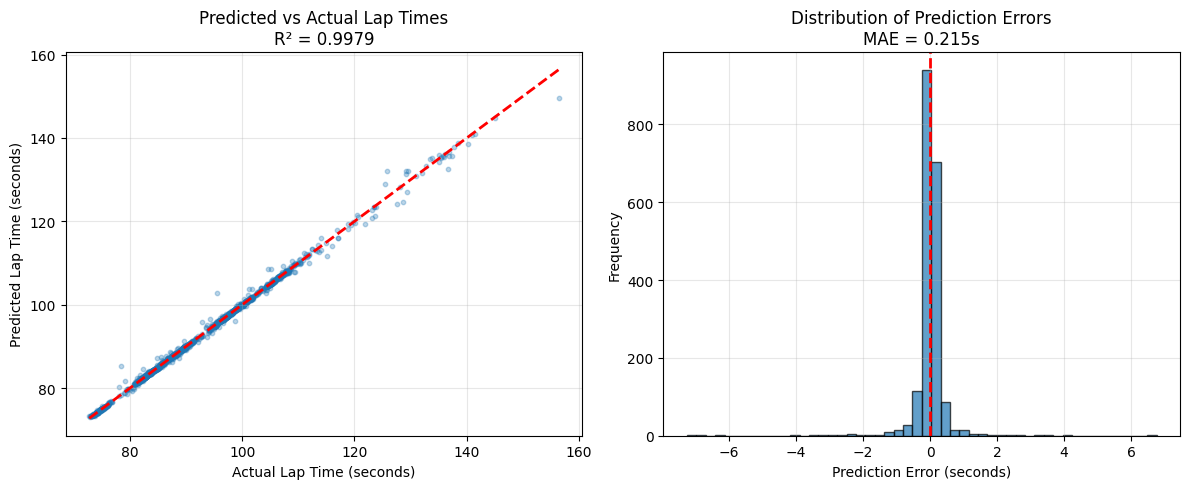


Prediction error statistics:
  Mean error: -0.010s
  Std error: 0.523s
  95% of predictions within ±0.595s


In [20]:
# Prediction vs Actual visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (seconds)')
plt.ylabel('Predicted Lap Time (seconds)')
plt.title(f'Predicted vs Actual Lap Times\nR² = {r2:.4f}')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (seconds)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Prediction Errors\nMAE = {mae:.3f}s')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrediction error statistics:")
print(f"  Mean error: {residuals.mean():.3f}s")
print(f"  Std error: {residuals.std():.3f}s")
print(f"  95% of predictions within ±{residuals.quantile(0.975):.3f}s")

In [23]:
# Save the enhanced models
print("Saving enhanced models...")

pickle.dump(xgb_model, open('../models/xgb_laptime.pk1', 'wb'))
pickle.dump(pipeline, open('../models/xgb_laptime_pipeline.pk1', 'wb'))

print("✓ Models saved successfully!")
print("  - xgb_laptime.pk1")
print("  - xgb_laptime_pipeline.pk1")
print(f"\nModel trained with {len(features)} features")
print(f"Performance: MAE = {mae:.3f}s, R² = {r2:.4f}")

Saving enhanced models...
✓ Models saved successfully!
  - xgb_laptime.pk1
  - xgb_laptime_pipeline.pk1

Model trained with 33 features
Performance: MAE = 0.215s, R² = 0.9979
